# Investgating Carbon Emissions of Neutron Transport Simulations.
Rosie Schiffmann <br>
University of Manchester <br>
July 2025

In this notebook, the carbon emissions produced by running some neutron transport simulation software is plotted. The software used is found inside "Project_3_11020606.ipynb", where CodeCarbon is implemented to track and export data about the energy consumption of simulating transmission, reflection and absortion rates of neutrons incident onto different thicknesses of lead, graphite and water "slabs". The simulation complexity is increased by increasing the number of neutrons incident onto the slabs.

 Various plots are investigated to demonstrate that:
- power is constant no matter what you're doing 
- energy consumption increases with time 
- energy consumption scales with simulation complexity in the way that we expect 

In [9]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re

# 1. Data
We will first accumulate necessary data into a master CSV file.

In [10]:
#identify relevant csv files inside repository
csv_files = glob.glob("neutron_penetration_emissions_*.csv")

summary_data = []

for file in csv_files:
    #identify and find mean of relevant data from CodeCarbon raw outputs
    df = pd.read_csv(file)
    mean_emissions = df['emissions'].mean()
    mean_duration = df['duration'].mean()
    mean_cpu_power = df['cpu_power'].mean()
    mean_ram_power = df['ram_power'].mean()
    mean_cpu_energy = df['cpu_energy'].mean()
    mean_ram_energy = df['ram_energy'].mean()
    match = re.search(r'neutron_penetration_emissions_(\d+)\.csv', file)
    neutrons = int(match.group(1)) if match else None

    #errors
    emissions_err = df['emissions'].std() / np.sqrt(len(df['emissions']))
    duration_err = df['duration'].std() / np.sqrt(len(df['duration']))
    cpu_power_err = df['cpu_power'].std() / np.sqrt(len(df['cpu_power']))
    ram_power_err = df['ram_power'].std() / np.sqrt(len(df['ram_power']))
    cpu_energy_err = df['cpu_energy'].std() / np.sqrt(len(df['cpu_energy']))
    ram_energy_err = df['ram_energy'].std() / np.sqrt(len(df['ram_energy']))
    
    summary_data.append({
        'filename': file,
        'neutron_number': neutrons,
        'mean_emissions': mean_emissions,
        'emissions_err' : emissions_err,
        'mean_duration': mean_duration,
        'duration_err' : duration_err,
        'mean_cpu_power': mean_cpu_power,
        'cpu_power_err' : cpu_power_err,
        'mean_ram_power' : mean_ram_power,
        'ram_power_err' : ram_power_err,
        'mean_cpu_energy' : mean_cpu_energy,
        'cpu_energy_err' : cpu_energy_err,
        'mean_ram_energy' : mean_ram_energy,
        'ram_energy_err' : ram_energy_err

    })

#create master csv file with data from runs.
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv("master_emissions_data.csv", index=False)


Below, we will format the master csv file, which contains all the plotting data for each different simulation complexity. 
- "neutron_number" represents the number of neutrons incident onto the slab.
- "mean_emissions" is the average gCO2e emitted by running the simulation for that number of neutrons, with associated error on the mean "emissions_err".
- "mean_duration" is the average runtime of the simulation in seconds, with associated error on the mean "duration_err".
- "mean_cpu_power" represents the average power used by the CPU during the simulation in Watts, with associated error on the mean "cpu_power_err".
- "mean_ram_power" represents the average power used by RAM during the simulation in Watts, with associated error on the mean "ram_power_err".
- "mean_cpu_energy" represents the average energy used by the CPU during the simulation in Joules, with associated error on the mean "cpu_energy_err".
- "mean_ram_energy" represents the average energy used by RAM during the simulation in Joules, with associated error on the mean "ram_energy_err".

NOTE: mean_cpu_power is exactly constant, as CodeCarbon doesn't have access to RAPL on Windows OS, so it falls back on constant Thermal Design Power (TDP).

In [21]:
df = pd.read_csv("master_emissions_data.csv")
df
print(df['ram_power_err'])

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: ram_power_err, dtype: float64


# 2. Plotting

In [46]:
def CPU_vs_RAM_plotting(x_variable, x_err, CPU_y_variable, CPU_y_err, RAM_y_variable, RAM_y_err, fit=False, fit_order=None):
    """
    Parameters: 
    - x_variable: string, name of x-axis variable for plotting from dataframe
    - x_err: string, name of error associated weith x-axis variable from dataframe
    - CPU_y_variable: string, name of y-axis variable for CPU plot from dataframe
    - CPU_y_err: string, name of error associated with CPU y-axis variable from dataframe
    - RAM_y_variable: string, name of y-axis variable for RAM plot from dataframe
    - RAM_y_err: string, name of error associated with RAM y-axis variable from dataframe
    - fit: bool, whether or not plot should have fitting
    - fit_order: int, order of fit if fit=True
    """
    plt.rcParams["figure.figsize"] = (14,6)
    fig, ax =  plt.subplots(1,2)

    #define units of selected variables
    units = ['J', 'gCO2e', 's', 'W', '']
    if x_variable=='mean_duration': x_unit=2
    if x_variable=='neutron_number': x_unit=4
    if CPU_y_variable=="mean_cpu_energy": y_unit=0
    if CPU_y_variable=="mean_cpu_power":y_unit=3
    if CPU_y_variable=="mean_emissions": y_unit=1
    
    if fit:
        #raise error if fit=True but no fit_order is provided
        if fit_order==None:
            raise ValueError("Order of fit must be provided if fit=True.")
        
        #CPU data fitting
        if np.any(df[CPU_y_err])==0.0: #do not use error-weighted fitting is errors=0
            coeffs_cpu = np.polyfit(df[x_variable], df[CPU_y_variable], deg=fit_order)
        else:
            coeffs_cpu = np.polyfit(df[x_variable], df[CPU_y_variable], deg=fit_order, w=df[CPU_y_err])
        poly_cpu = np.poly1d(coeffs_cpu)
        x_fit = np.linspace(df[x_variable].min(), df[x_variable].max(), 100)
        ax[0].plot(x_fit, poly_cpu(x_fit), 'r--', label=f"Fit (order {fit_order})", linewidth = 0.5)

        #RAM data fitting
        if np.any(df[RAM_y_err])==0.0: #do not use error-weighted fitting is errors=0
            coeffs_ram = np.polyfit(df[x_variable], df[RAM_y_variable], deg=fit_order)
        else:
            coeffs_ram = np.polyfit(df[x_variable], df[RAM_y_variable], deg=fit_order, w=df[RAM_y_err])
        poly_ram = np.poly1d(coeffs_ram)
        ax[1].plot(x_fit, poly_ram(x_fit), 'r--', label=f"Fit (order {fit_order})", linewidth = 0.5)

    #plotting CPU data
    ax[0].errorbar(df[x_variable], df[CPU_y_variable], yerr = df[CPU_y_err], fmt = "none", capsize = 2, label = "CPU data")
    ax[0].set_title(f'{CPU_y_variable} vs {x_variable}')
    ax[0].set_xlabel(f'{x_variable}, {units[x_unit]}')
    ax[0].set_ylabel(f'{CPU_y_variable}, {units[y_unit]}')

    #plotting RAM data
    ax[1].errorbar(df[x_variable], df[RAM_y_variable], yerr = df[RAM_y_err], fmt = "none", capsize = 2, label = "RAM data")
    ax[1].set_title(f'{RAM_y_variable} vs {x_variable}')
    ax[1].set_xlabel(f'{x_variable}, {units[x_unit]}')
    ax[1].set_ylabel(f'{RAM_y_variable}, {units[y_unit]}')

    #plot details
    for i in range(2):
        ax[i].grid()
        ax[i].legend()
    return None   

# 2.1 Energy consumption vs time
Here, we demonstrate that energy consumption increases linearly with run-time of the simulation.

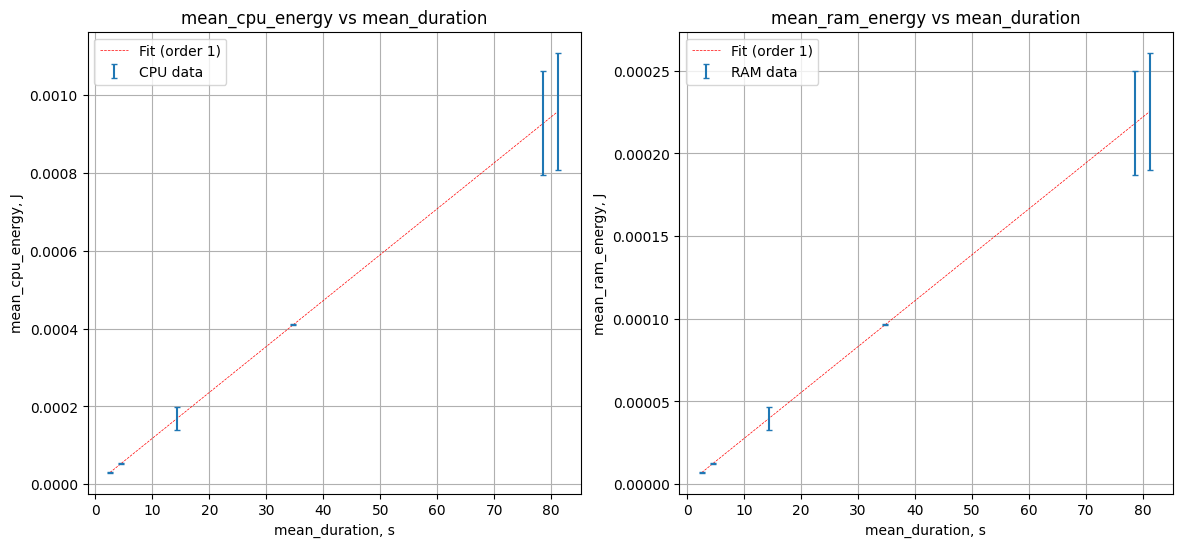

In [47]:
CPU_vs_RAM_plotting("mean_duration", "duration_error", 
         "mean_cpu_energy", "cpu_energy_err", 
         "mean_ram_energy", "ram_energy_err", 
         True, 1)

Now, lets demonstrate how CPU and RAM energy change with simulation intensity.

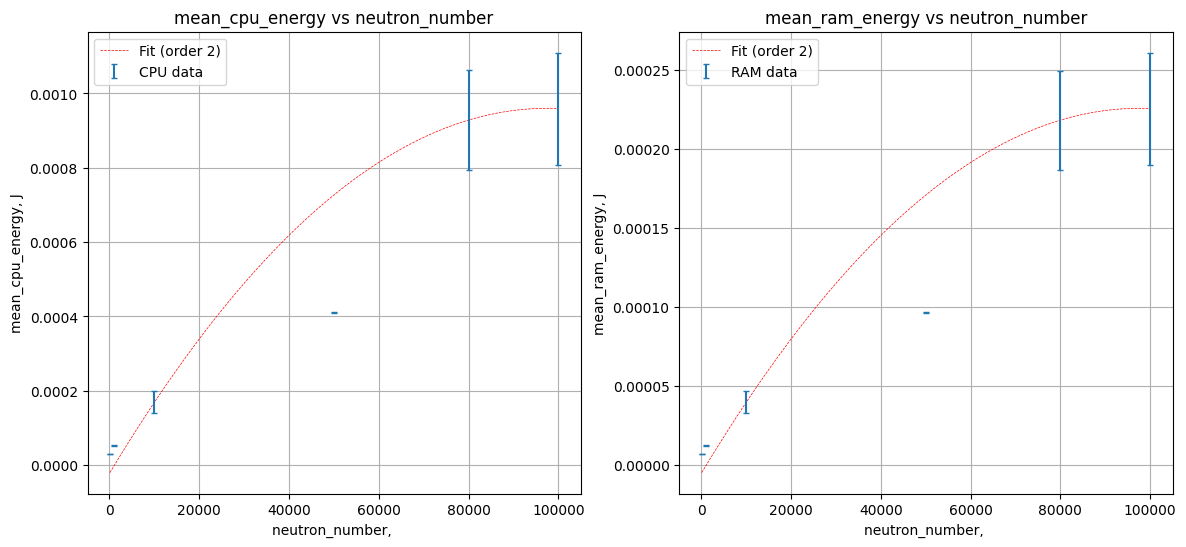

In [51]:
CPU_vs_RAM_plotting("neutron_number", None, 
         "mean_cpu_energy", "cpu_energy_err", 
         "mean_ram_energy", "ram_energy_err", 
         True, 2)

# 2.2 Power consumption

Here we will demonstrate that power consumption remains constant with time.

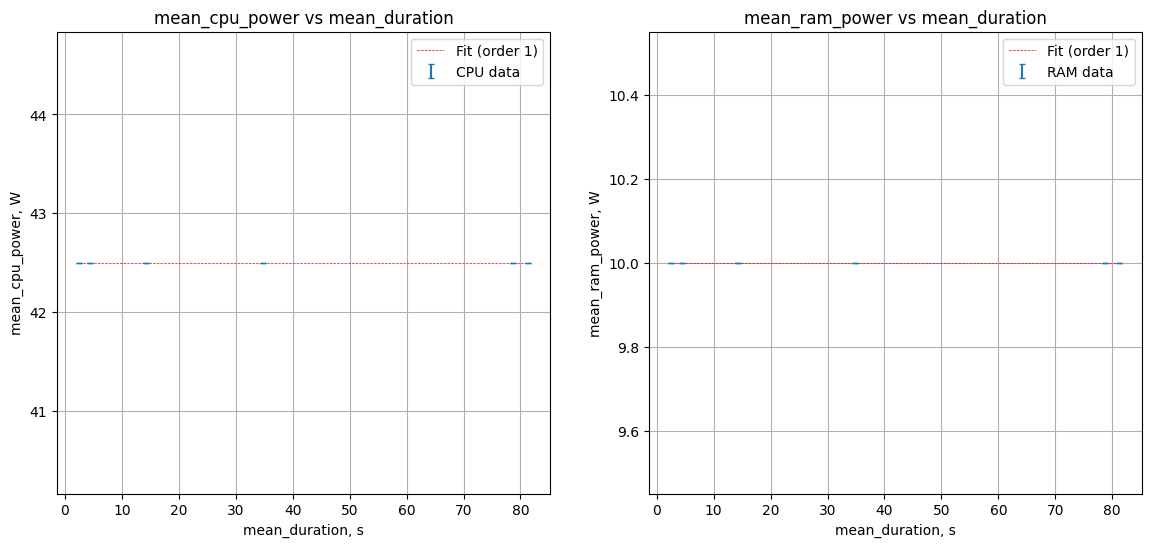

In [48]:
CPU_vs_RAM_plotting("mean_duration", "duration_err", 
         "mean_cpu_power", "cpu_power_err", 
         "mean_ram_power", "ram_power_err", True, 1)

Now, we can demonstrate how CPU/RAM power changes with simulation intensity (neutron number).

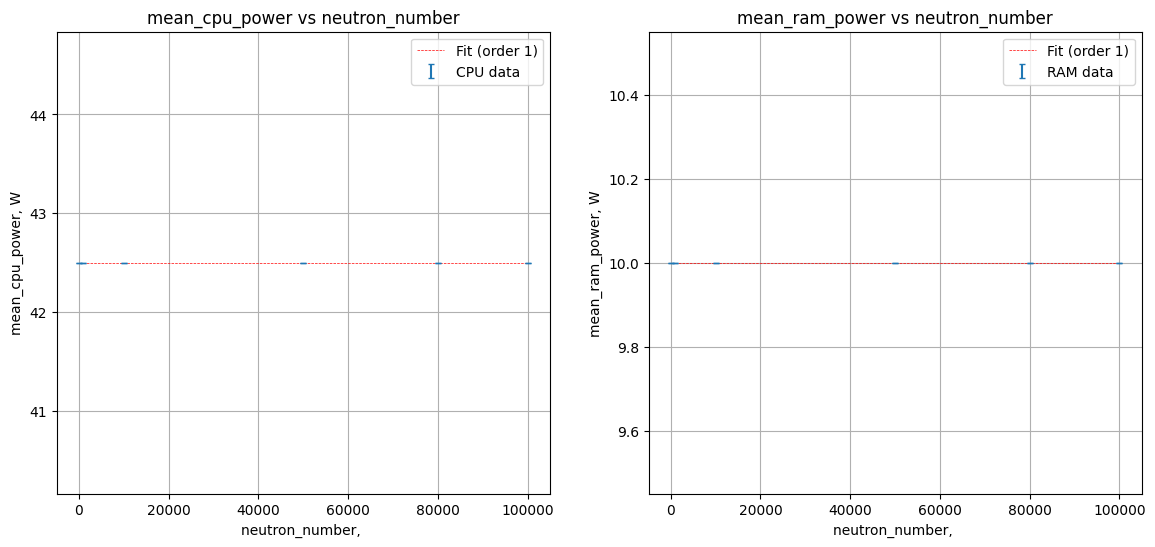

In [49]:
CPU_vs_RAM_plotting("neutron_number", None, "mean_cpu_power", "cpu_power_err", "mean_ram_power", "ram_power_err", True, 1)

# 2.3 Emissions
Here we will plot how emissions change with respect to simulation complexity.

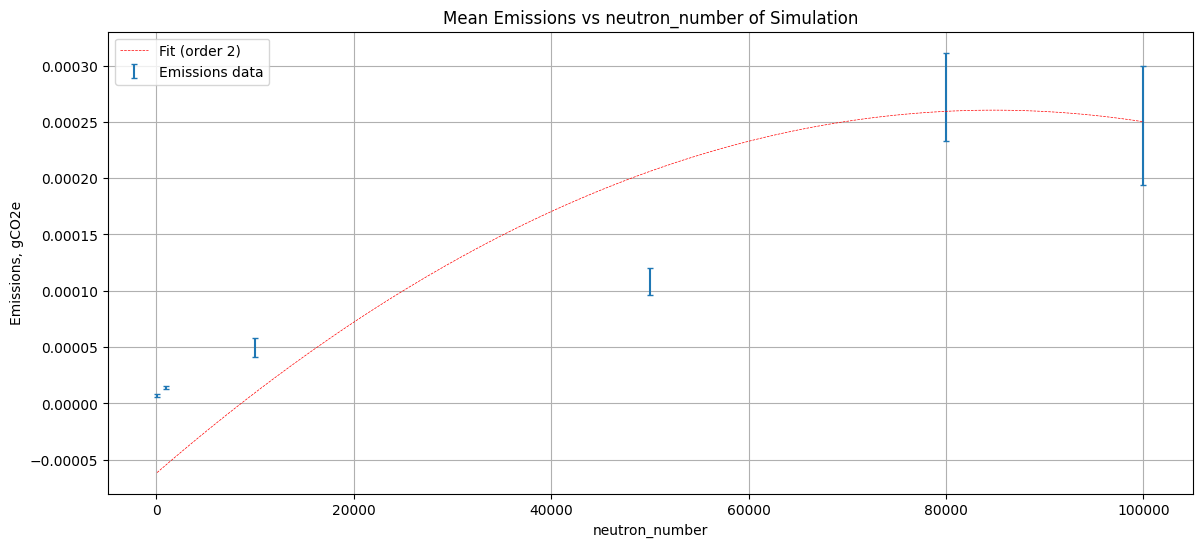

In [61]:
def emissions_plotter(df, x_variable, fit=False, fit_order=None):
    plt.figure()
    plt.errorbar(df[x_variable], df['mean_emissions'], yerr=df['emissions_err'], fmt="none", capsize=2, label = "Emissions data")

    if np.any(df['emissions_err'])==0.0: #do not use error-weighted fitting is errors=0
        coeffs = np.polyfit(df[x_variable], df['mean_emissions'], deg=fit_order)
    else:
        coeffs = np.polyfit(df[x_variable], df['mean_emissions'], deg=fit_order, w=df['emissions_err'])
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(df[x_variable].min(), df[x_variable].max(), 100)
    plt.plot(x_fit, poly(x_fit), 'r--', label=f"Fit (order {fit_order})", linewidth = 0.5)

    if x_variable=='mean_duration': plt.xlabel(f'Simulation run-time, s')
    else: plt.xlabel(f'{x_variable}')
    plt.ylabel('Emissions, gCO2e')
    plt.title(f'Mean Emissions vs {x_variable} of Simulation')
    plt.grid()
    plt.legend()
    plt.show()

emissions_plotter(df, "neutron_number", True, 2)

Now, we demonstrate how emissions change with runtime of simulation.

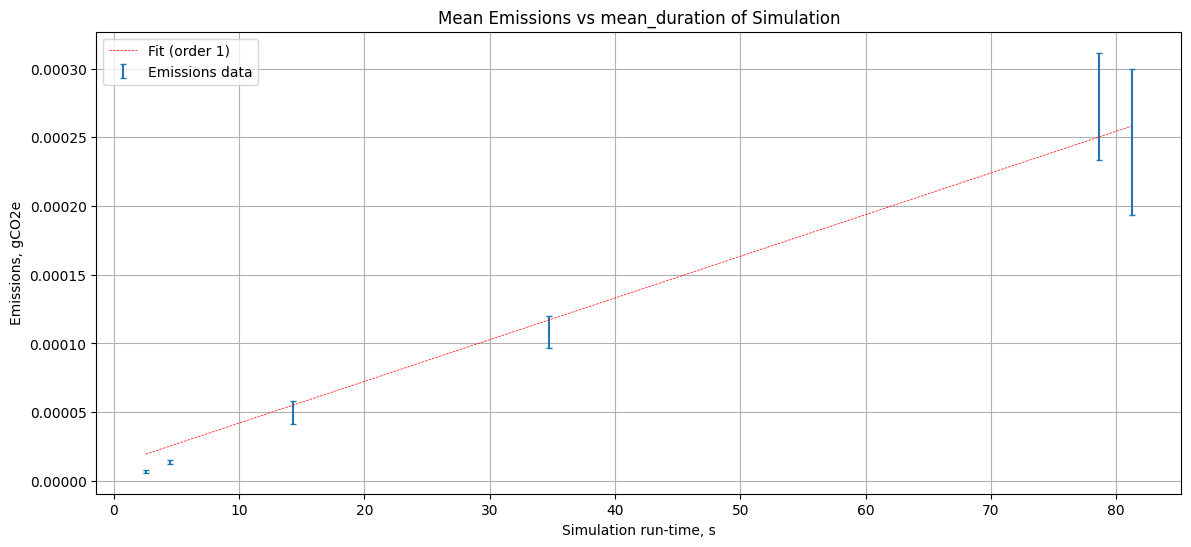

In [62]:
emissions_plotter(df, "mean_duration", True, 1)